In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [123]:
cardio = pd.read_csv('dataset.csv')

In [124]:
#Check any null values
cardio.isnull().any()

Gender                    False
Age                       False
Height(cm)                False
Weight(kg)                False
Family_history            False
Alcohol                   False
Junk_food                 False
Vege_day                  False
Meals_day                 False
Snack                     False
Smoking                   False
Water_intake(L)           False
Transportation            False
Exercise                  False
TV                        False
Income                    False
Discipline                False
Cardiovascular_risk(y)    False
dtype: bool

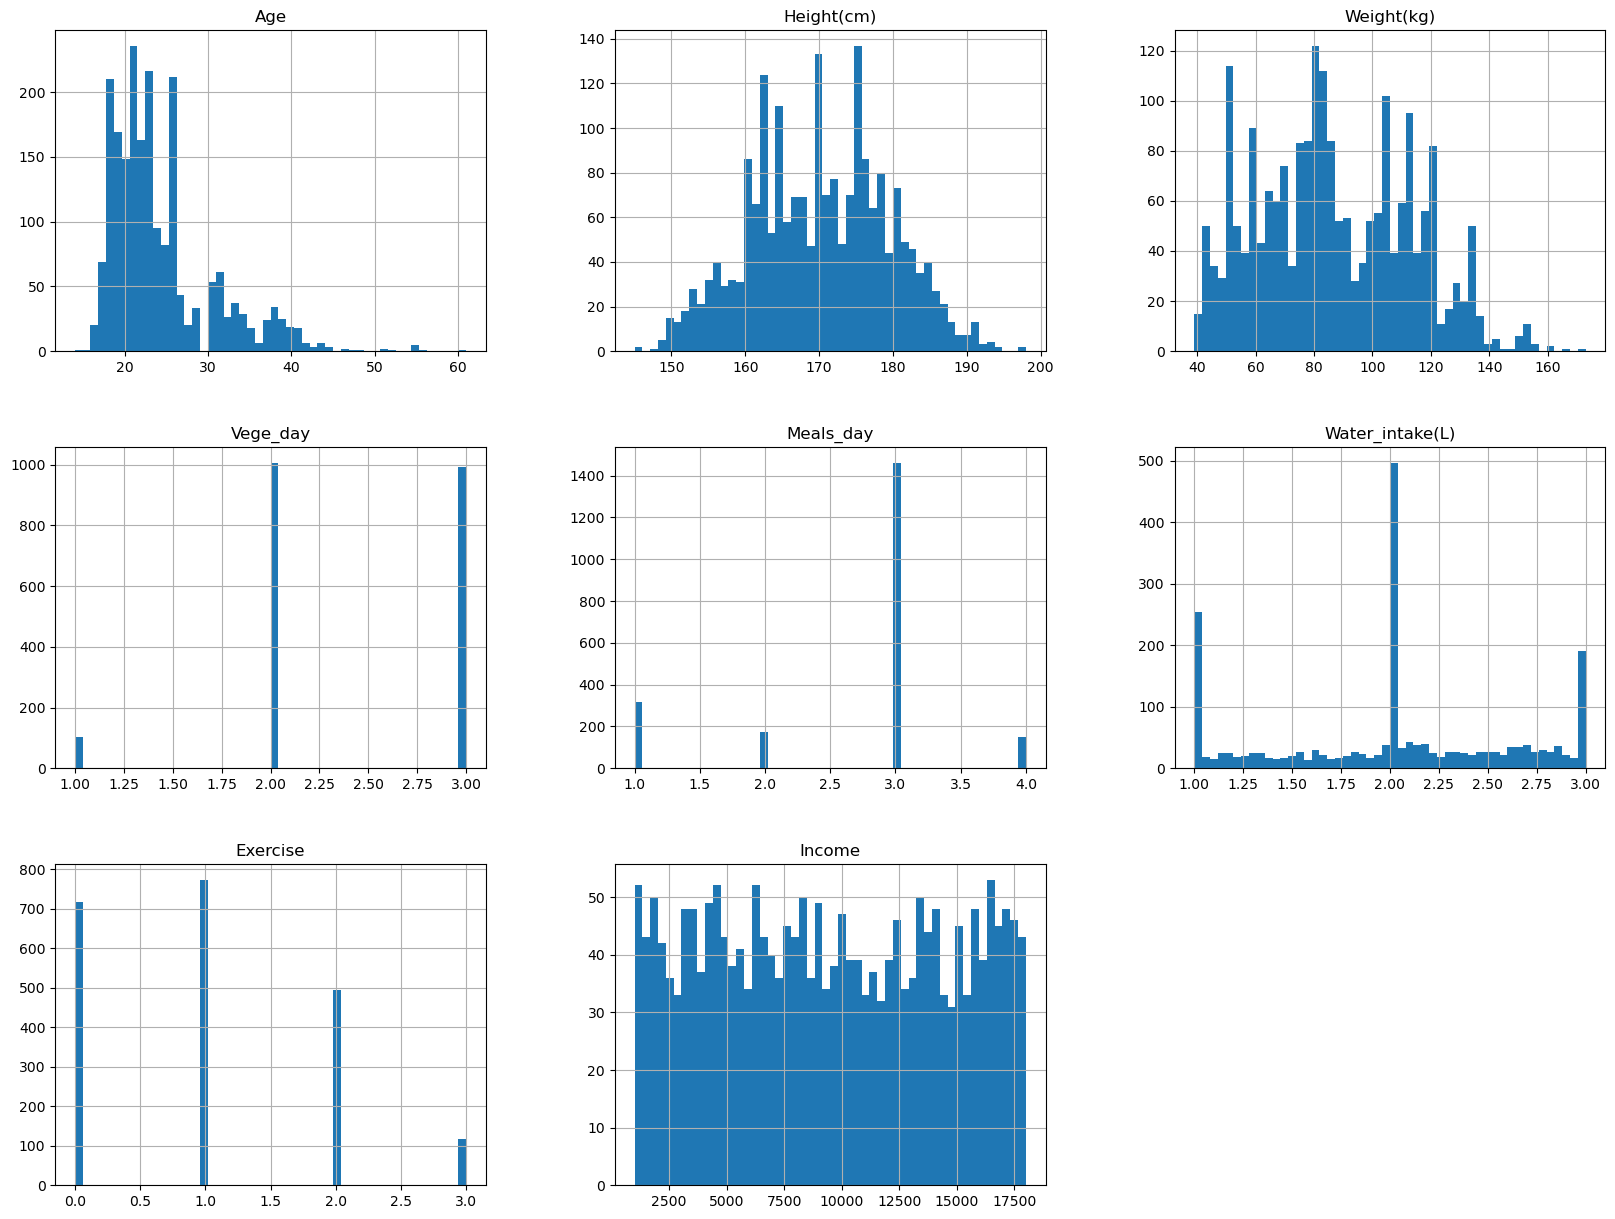

In [125]:
cardio.hist(bins=50, figsize=(20,15))
plt.show()

In [126]:
#Data preprocessing

# Separate the output vector from the input matrix
X = cardio.drop(['Cardiovascular_risk(y)'], axis=1)
y = cardio['Cardiovascular_risk(y)']

print ('X: shape=', X.shape, 'type=', type(X))
print ('y: shape=', y.shape, 'type=', type(y))

#Extract height,weight feature -> BMI
X = X.drop(['Height(cm)','Weight(kg)'],axis=1)

height = cardio['Height(cm)']
weight = cardio['Weight(kg)']

height = height/100 # convert cm to m
bmi = weight/ height**2

X = pd.concat([X, bmi.rename('BMI')], axis=1)

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ('full set shape=', X.shape)
print ('train shape=', X_train.shape)
print ('test shape=', X_test.shape)

# Split the input matrix into numerical and categorical sets
X_train_num = X_train.drop(['Gender','Family_history','Alcohol','Junk_food','Snack','Smoking','Transportation','TV','Discipline'], axis = 1)
X_gender = X_train['Gender']
X_fam = X_train['Family_history']
X_alcohol = X_train['Alcohol']
X_junk = X_train['Junk_food']
X_snack = X_train['Snack']
X_smoke = X_train['Smoking']
X_transport = X_train['Transportation']
X_tv = X_train['TV']
X_discipline = X_train['Discipline']

#standardization numeric data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy = False)
scaler.fit(X_train_num)       
X_train_num_tr = scaler.transform(X_train_num)

print('>>> Mean of all columns:\n', X_train_num_tr.mean(axis=0))
print('\n>>> Std of all columns:\n', X_train_num_tr.std(axis=0))

#one hot encoding - gender,fam, junk,smoking, transport,discipline
from sklearn.preprocessing import LabelBinarizer

gender_encoder = LabelBinarizer()
fam_encoder = LabelBinarizer()
junk_encoder = LabelBinarizer()
smoke_encoder = LabelBinarizer()
discipline_encoder = LabelBinarizer()
transport_encoder = LabelBinarizer()

X_gender_tr = gender_encoder.fit_transform(X_gender) 
X_fam_tr = fam_encoder.fit_transform(X_fam)
X_junk_tr = junk_encoder.fit_transform(X_junk)
X_smoke_tr = smoke_encoder.fit_transform(X_smoke)
X_discipline_tr = discipline_encoder.fit_transform(X_discipline)
X_transport_tr = transport_encoder.fit_transform(X_transport)

#label encoding - alcohol, snack,tv
from sklearn.preprocessing import LabelEncoder

alcohol_encoder = LabelEncoder()
label_mapping = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}
alcohol_encoder.classes_ = [k for k in label_mapping.keys()]
X_alcohol_tr = alcohol_encoder.fit_transform([label_mapping[label] for label in X_alcohol])

snack_encoder = LabelEncoder()
label_mapping = {'No': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
snack_encoder.classes_ = [k for k in label_mapping.keys()]
X_snack_tr = snack_encoder.fit_transform([label_mapping[label] for label in X_snack])

tv_encoder = LabelEncoder()
label_mapping = {'rare': 0, 'moderate': 1, 'often': 2}
tv_encoder.classes_ = [k for k in label_mapping.keys()]
X_tv_tr = tv_encoder.fit_transform([label_mapping[label] for label in X_tv])


#Finalize training set
X_alcohol_tr = X_alcohol_tr.reshape(-1, 1)
X_snack_tr = X_snack_tr.reshape(-1, 1)
X_tv_tr = X_tv_tr.reshape(-1, 1)
X_train_tr = np.hstack([X_train_num_tr, X_gender_tr, X_fam_tr, X_junk_tr,X_smoke_tr, X_transport_tr, X_discipline_tr,
                        X_alcohol_tr, X_snack_tr, X_tv_tr])

print('X_train_tr shape:', X_train_tr.shape)

X: shape= (2100, 17) type= <class 'pandas.core.frame.DataFrame'>
y: shape= (2100,) type= <class 'pandas.core.series.Series'>
full set shape= (2100, 16)
train shape= (1680, 16)
test shape= (420, 16)
>>> Mean of all columns:
 [-1.69176842e-17  6.34413157e-18 -2.64338815e-16  3.93336157e-16
  1.69969858e-16  1.50144447e-16 -5.03301104e-16]

>>> Std of all columns:
 [1. 1. 1. 1. 1. 1. 1.]
X_train_tr shape: (1680, 20)


In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [128]:


# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train_tr, y_train)

# Predict on the train set to check the performance
y_pred_cv = cross_val_predict (log_reg, X_train_tr, y_train, cv=3)



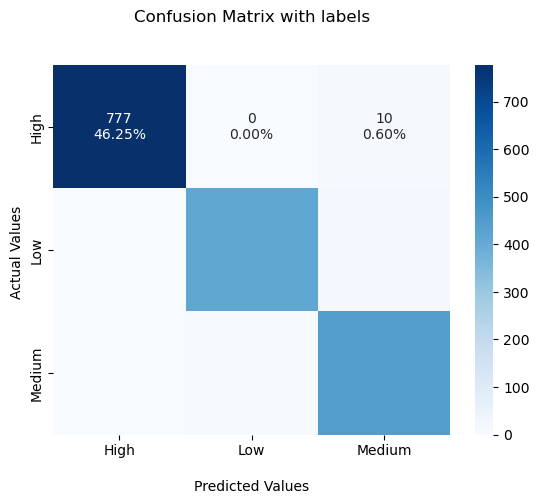

In [129]:
#Confusion matrix
cm = confusion_matrix (y_train, y_pred_cv)
#print(cm)

#visualising confusion matrix
def plot_confusion_matrix(cm):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(3,3)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['High','Low','Medium'])
    ax.yaxis.set_ticklabels(['High','Low','Medium'])
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()

plot_confusion_matrix(cm)

In [130]:
#Classification report
class_report = classification_report(y_train, y_pred_cv)

print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.99      0.99       787
         low       0.98      0.95      0.97       439
      medium       0.93      0.98      0.96       454

    accuracy                           0.98      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.98      0.98      0.98      1680



In [131]:
#preprocess test set
X_test_num = X_test.drop(['Gender','Family_history','Alcohol','Junk_food','Snack','Smoking','Transportation','TV','Discipline'], axis = 1)

X_gender_test = X_test['Gender']
X_fam_test = X_test['Family_history']
X_alcohol_test = X_test['Alcohol']
X_junk_test = X_test['Junk_food']
X_snack_test = X_test['Snack']
X_smoke_test = X_test['Smoking']
X_transport_test = X_test['Transportation']
X_tv_test = X_test['TV']
X_discipline_test = X_test['Discipline']

X_test_num_tr = scaler.transform(X_test_num)

X_gender_test_tr = gender_encoder.transform(X_gender_test) 
X_fam_test_tr = fam_encoder.transform(X_fam_test)
X_junk_test_tr = junk_encoder.transform(X_junk_test)
X_smoke_test_tr = smoke_encoder.transform(X_smoke_test)
X_transport_test_tr = transport_encoder.transform(X_transport_test)
X_discipline_test_tr = discipline_encoder.transform(X_discipline_test)


label_mapping = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}
X_alcohol_test_tr = np.array([label_mapping[label] for label in X_alcohol_test])

label_mapping = {'No': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
X_snack_test_tr = np.array([label_mapping[label] for label in X_snack_test])

label_mapping = {'rare': 0, 'moderate': 1, 'often': 2}
X_tv_test_tr = np.array([label_mapping[label] for label in X_tv_test])

X_alcohol_test_tr = X_alcohol_test_tr.reshape(-1, 1)
X_snack_test_tr = X_snack_test_tr.reshape(-1, 1)
X_tv_test_tr = X_tv_test_tr.reshape(-1, 1)
X_test_tr = np.hstack([X_test_num_tr, X_gender_test_tr, X_fam_test_tr, X_junk_test_tr,X_smoke_test_tr, X_transport_test_tr, 
                       X_discipline_test_tr, X_alcohol_test_tr, X_snack_test_tr, X_tv_test_tr])

print('X_test_tr shape:', X_test_tr.shape)

X_test_tr shape: (420, 20)


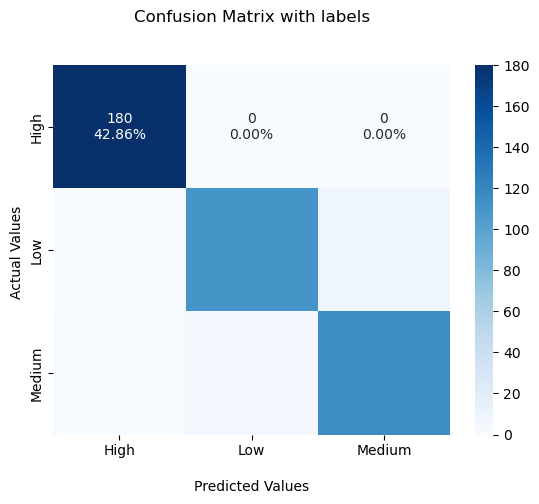

In [132]:
# predict on test set
y_pred_test = log_reg.predict(X_test_tr) 

cm = confusion_matrix (y_test, y_pred_test)
plot_confusion_matrix(cm)

In [133]:
class_report = classification_report(y_test, y_pred_test)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        high       0.99      1.00      0.99       180
         low       0.96      0.93      0.95       118
      medium       0.94      0.95      0.94       122

    accuracy                           0.97       420
   macro avg       0.96      0.96      0.96       420
weighted avg       0.97      0.97      0.97       420



In [134]:
#fine tune the model by grid searching
logistic_reg = LogisticRegression(random_state=42)

#some solvers in LogisticRegression does not support all types of penalties
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'sag'], 'max_iter': [100, 500, 1000, 2000]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': [100, 500, 1000, 2000]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['saga'], 'max_iter': [100, 500, 1000, 2000]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'],'l1_ratio': [0.5, 0.7, 0.9], 'max_iter': [100, 500, 1000,2000]}
]

#perform grid search, n_jobs for parallel processing
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
print ('Performing grid search...', end = '')
grid_search.fit(X_train_tr, y_train)
print('done')

Performing grid search...done


C:\Users\wongk\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [135]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=1, max_iter=500, penalty='l1', random_state=42,
                   solver='saga')

In [136]:
# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test_tr)
cm = confusion_matrix (y_test, y_pred_test)
print(cm)

[[180   0   0]
 [  0 114   4]
 [  0   0 122]]


In [137]:
#classification report
class_report = classification_report(y_test, y_pred_test)
class_report_dict = classification_report(y_test, y_pred_test, output_dict=True)
macro_precision =  class_report_dict['macro avg']['precision'] 
macro_recall = class_report_dict['macro avg']['recall']    
macro_f1 = class_report_dict['macro avg']['f1-score']
accuracy = class_report_dict['accuracy']

print(class_report)

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       180
         low       1.00      0.97      0.98       118
      medium       0.97      1.00      0.98       122

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



In [138]:
#insight on important data
feature_importances = grid_search.best_estimator_.coef_[0]

attributes = (X_train_num.columns.tolist() 
              + list(gender_encoder.classes_)
              + ['fam_' + value for value in fam_encoder.classes_]
              + ['junk_' + value for value in junk_encoder.classes_]
              + ['smoke_' + value for value in smoke_encoder.classes_]
              + ['discipline_' + value for value in discipline_encoder.classes_]
              + list(transport_encoder  .classes_)
             )

sorted(zip(feature_importances, attributes), reverse=True)

[(23.428770179990106, 'BMI'),
 (0.9443941771116007, 'fam_no'),
 (0.2142483540178877, 'bicycle'),
 (0.0, 'smoke_yes'),
 (0.0, 'smoke_no'),
 (0.0, 'junk_yes'),
 (0.0, 'junk_no'),
 (0.0, 'fam_yes'),
 (0.0, 'discipline_yes'),
 (0.0, 'discipline_no'),
 (0.0, 'car'),
 (0.0, 'bus'),
 (0.0, 'Water_intake(L)'),
 (0.0, 'Vege_day'),
 (0.0, 'Male'),
 (0.0, 'Income'),
 (0.0, 'Age'),
 (-0.014392718041790277, 'Exercise'),
 (-0.09518981282511269, 'Meals_day'),
 (-0.6153182075214575, 'Female')]

In [139]:
# Kenji
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

forest_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)

forest_clf.fit(X_train_tr, y_train)

y_pred_forest = forest_clf.predict(X_train_tr)

forest_cm = confusion_matrix (y_train, y_pred_forest)

forest_cm

array([[787,   0,   0],
       [  0, 439,   0],
       [  1,   0, 453]], dtype=int64)

In [140]:
forest_class_report = classification_report(y_train, y_pred_forest)
print(forest_class_report)

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       787
         low       1.00      1.00      1.00       439
      medium       1.00      1.00      1.00       454

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680



In [141]:
y_pred_test_forest = forest_clf.predict(X_test_tr) 

forest_test_cm = confusion_matrix (y_test, y_pred_test_forest)

forest_test_cm

array([[180,   0,   0],
       [  0, 118,   0],
       [  1,   1, 120]], dtype=int64)

In [142]:
forest_class_report_test = classification_report(y_test, y_pred_test_forest)
print(forest_class_report_test)

              precision    recall  f1-score   support

        high       0.99      1.00      1.00       180
         low       0.99      1.00      1.00       118
      medium       1.00      0.98      0.99       122

    accuracy                           1.00       420
   macro avg       1.00      0.99      0.99       420
weighted avg       1.00      1.00      1.00       420



In [143]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    #'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)] (previous code)
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=400, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform randomized search with 100 iterations and 5-fold cross-validation
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')

# Fit the randomized search to the data
random_search.fit(X_train_tr, y_train)

# Best hyperparameters found
best_params = random_search.best_params_

# Train the model with the best parameters on the full training set
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_tr, y_train)

# Predict on the test set
y_pred_best_rf = best_rf.predict(X_test_tr)

# Evaluate the model
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_class_report = classification_report(y_test, y_pred_best_rf)

# Output the best parameters, accuracy, and classification report
print(best_params)
print(best_rf_accuracy)
print(best_rf_class_report)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 244, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       180
         low       1.00      1.00      1.00       118
      medium       1.00      1.00      1.00       122

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



In [147]:
forest_cm = confusion_matrix(y_test, y_pred_best_rf)
forest_cm

array([[180,   0,   0],
       [  0, 118,   0],
       [  0,   0, 122]], dtype=int64)